In [1]:
# Install or upgrade the package if necessary
#!pip install statsmodels
#!pip install --upgrade statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Arctic Sea Ice Minimum data from NASA, coverage from 1979 to 2021
# https://climate.nasa.gov/vital-signs/arctic-sea-ice/
data = pd.read_csv('2264_N_09_extent_v3.0.csv')
data = data[['year', ' extent', '   area']]

### Basic information of the data:

In [3]:
data.describe()

,year,extent,area
count,42.000000,42.000000,42.000000
mean,1999.500000,6.017143,4.153810
std,12.267844,1.149838,0.791818
min,1979.000000,3.570000,2.410000
25%,1989.250000,4.955000,3.500000
50%,1999.500000,6.130000,4.295000
75%,2009.750000,7.040000,4.587500
max,2020.000000,7.670000,5.640000


### Firstly, we try to decompose the time series data into trend, seasonal and residual

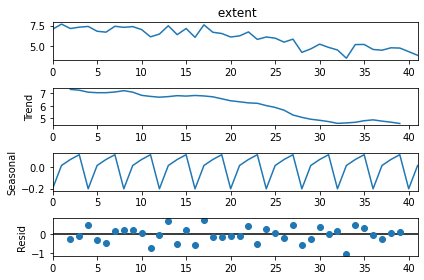

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import freq_to_period
import matplotlib.pyplot as plt

analysis = seasonal_decompose(data[" extent"], period=4)

analysis.plot()

plt.show()

### Now we need to examine the stationarity of the data:

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]
print("Stationary test: ", test_stationarity(data[' extent']))
print("First order difference stationary test: ", test_stationarity(data[' extent'].diff().dropna()))
print("Second order difference stationary test: ", test_stationarity(data[' extent'].diff().diff().dropna()))

Stationary test:  0.9497972034849789
First order difference stationary test:  0.028319022404578592
Second order difference stationary test:  2.9445786493227132e-08


### By looking into acf and pacf graph we can define the order for our model

<Figure size 432x288 with 0 Axes>

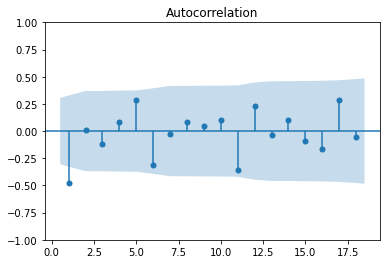

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

columns = [' extent']

for col in columns:
    plt.figure()
    plot_acf(data[col].diff().dropna(), lags=18, zero=False)
    
plt.show()

<Figure size 432x288 with 0 Axes>

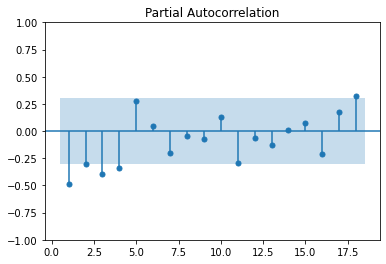

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

columns = [' extent']

for col in columns:
    plt.figure()
    plot_pacf(data[col].diff().dropna(), lags=18, zero=False)
    
plt.show()

<Figure size 432x288 with 0 Axes>

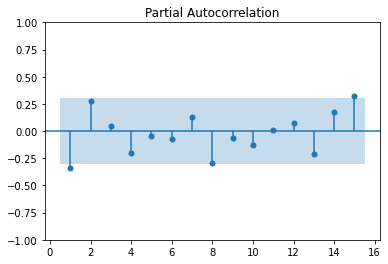

In [8]:
from statsmodels.graphics.tsaplots import _prepare_data_corr_plot, _plot_corr
import statsmodels.graphics.utils as utils
from statsmodels.tsa.stattools import pacf

def plot_pacf_drop(x, ax=None, lags=None, alpha=.05, method='ywadjusted',
              use_vlines=True, title='Partial Autocorrelation', zero=True,
              vlines_kwargs=None, drop_no=0, **kwargs):
    
    lags_orig=lags
    fig, ax = utils.create_mpl_ax(ax)
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs
    lags, nlags, irregular = _prepare_data_corr_plot(x, lags, zero)
    confint = None
    if alpha is None:
        acf_x = pacf(x, nlags=nlags, alpha=alpha, method=method)
    else:
        acf_x, confint = pacf(x, nlags=nlags, alpha=alpha, method=method)

    if drop_no:
        acf_x = acf_x[drop_no+1:]
        confint = confint[drop_no+1:]
        lags, nlags, irregular = _prepare_data_corr_plot(x, lags_orig-drop_no, zero)
        
    _plot_corr(ax, title, acf_x, confint, lags, False, use_vlines,
               vlines_kwargs, **kwargs)

    return fig

for col in columns:
    plt.figure()
    plot_pacf_drop(data[col].diff().dropna(), lags=18, drop_no=3, zero=False)
    
plt.show()

### Finally we can build the model for predicting

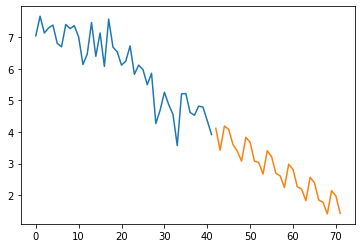

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast


stlf = STLForecast(data[" extent"], ARIMA, model_kwargs=dict(order=(4, 2, 1)), period=5)
stlf_res = stlf.fit()

forecast = stlf_res.forecast(30)
plt.plot(data[" extent"])
plt.plot(forecast)
plt.show()